In [1]:
datasetName = 'brain_ACC_AllenBrainAtlas'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_ACC_AllenBrainAtlas")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = F, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,V1,V2,V3,V4,V5
,<chr>,<int>,<int>,<int>,<int>
1,3.8-1.2,0,0,0,0
2,3.8-1.3,0,0,0,0
3,3.8-1.4,0,0,0,0
4,3.8-1.5,0,0,0,0
5,5-HT3C2,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
SM-DAIFE_S81_E1-50,brain,ACC,L1,normal,H200.1023,F,15695
SM-DAIFE_S82_E1-50,brain,ACC,L1,normal,H200.1023,F,15695
SM-DAIFE_S83_E1-50,brain,ACC,L1,normal,H200.1023,F,15695
SM-DAIFE_S84_E1-50,brain,ACC,L1,normal,H200.1023,F,15695
SM-DAIFE_S85_E1-50,brain,ACC,L1,normal,H200.1023,F,15695


[1] NA NA NA NA NA

In [4]:
genes <- data.matrix[, 1]
genes[duplicated(genes)]
# 2-Mar: 30913, 30917
# 1-Mar: 30912, 30914

character(0)

In [5]:
row.names(data.matrix) = data.matrix[, 1]
data.matrix <- data.matrix[, -1]
colnames(data.matrix) <- row.names(data.metadata)
data.matrix[1:5, 1:5]

,SM-DAIFE_S81_E1-50,SM-DAIFE_S82_E1-50,SM-DAIFE_S83_E1-50,SM-DAIFE_S84_E1-50,SM-DAIFE_S85_E1-50
,<int>,<int>,<int>,<int>,<int>
3.8-1.2,0,0,0,0,0
3.8-1.3,0,0,0,0,0
3.8-1.4,0,0,0,0,0
3.8-1.5,0,0,0,0,0
5-HT3C2,0,0,0,0,1


In [6]:
# Pre-processing
min.cells = 3
min.features = 200
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 5
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

In [7]:
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = '^MT-')
# dataobj <- subset(dataobj, subset = nFeature_RNA > 200)
# dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [8]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 4000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [9]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  SLC1A3, PTGDS, PON2, RNF219-AS1, ZBTB20, NCKAP5, KANK1, ATP1A2, LOC105369345, NHSL1 
	   FGFR3, NDRG2, BMPR1B, GLUL, DOCK1, MAML2, CDH20, RFTN2, QKI, GLI3 
	   SLCO1C1, LOC101927437, PARD3B, DOCK5, LINC00499, SLC25A18, ACSS1, PRODH, FBXL7, PTN 
Negative:  ASIC2, KCNC2, GALNTL6, CNTN5, GRIP1, UNC5D, ZNF804B, CBLN2, DPP10, SYNPR 
	   KIAA1217, LOC105371832, UNC13C, FSTL5, ZNF804A, LINC01378, TRHDE, SLIT2, PDZRN4, CNR1 
	   CCK, GRIN3A, ROBO1, ZNF385D, PTCHD4, SCG2, IL1RAPL2, EPHA6, SGCZ, DCC 
PC_ 2 
Positive:  APBB1IP, LPAR6, DOCK8, CX3CR1, CSF1R, ADAM28, CD74, SYK, TBXAS1, C3 
	   BLNK, P2RY12, INPP5D, FYB, ST6GAL1, AOAH, LOC101929497, SLCO2B1, CSF3R, RCSD1 
	   PALD1, SRGAP2, C10orf11, PTPRC, FLI1, MS4A7, ADAP2, IKZF1, PIK3R5, LINC01141 
Negative:  ST18, PLP1, CERCAM, LOC101929249, MOG, ENPP2, MOBP, UGT8, CARNS1, OPALIN 
	   CLDN11, TF, MYRF, PLEKHH1, LOC101927459, RNF220, SCD, FA2H, PXK, PHLDB1 
	   ABCA8, PTGDS, GPM6B, FOLH1, PPP1R14A, CRYAB, CNDP1, CNTN2, LOC101927

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


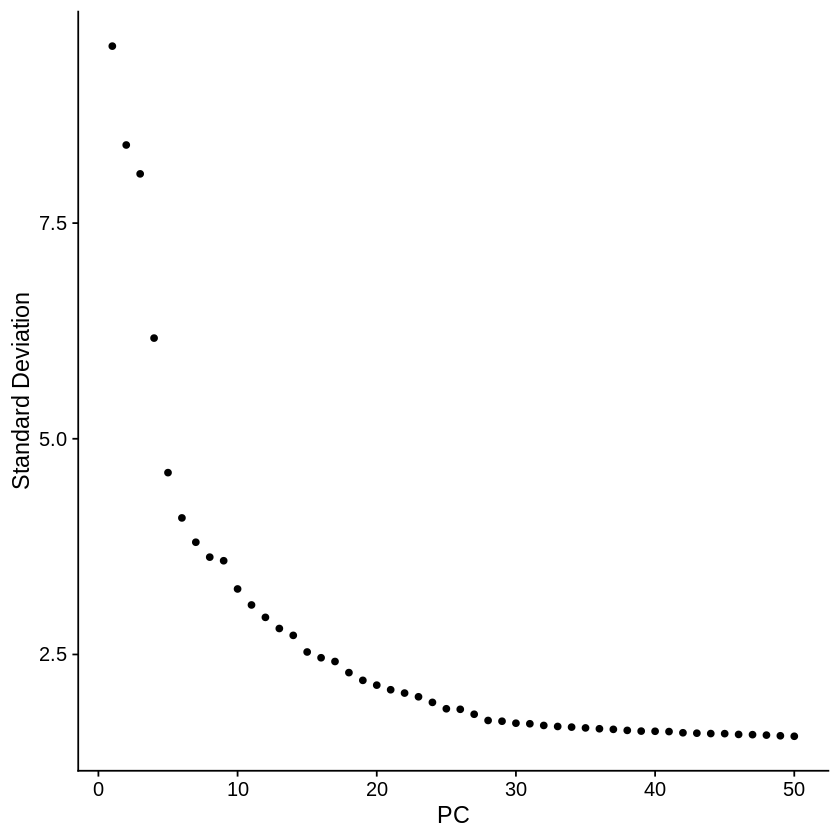

In [10]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [11]:
dev.off()
pcDim = 10 # set as 75 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
23:39:54 UMAP embedding parameters a = 0.9922 b = 1.112

23:39:54 Read 7280 rows and found 10 numeric columns

23:39:54 Using Annoy for neighbor search, n_neighbors = 30

23:39:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

23:39:55 Writing NN index file to temp file /tmp/Rtmphotuld/file6fb85157370c

23:39:55 Searching Annoy index using 1 thread, search_k = 3000

23:39:57 Annoy recall = 100%

23:39:57 Commencing smooth kNN distance calibration using 1 thread

23:39:58 Initializing fr

In [12]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6, n.start = 10)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7280
Number of edges: 252733

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9322
Number of communities: 16
Elapsed time: 0 seconds


23:40:17 UMAP embedding parameters a = 0.9922 b = 1.112

23:40:17 Read 7280 rows and found 10 numeric columns

23:40:17 Using Annoy for neighbor search, n_neighbors = 30

23:40:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

23:40:18 Writing NN index file to temp file /tmp/Rtmphotuld/file6fb83c729496

23:40:18 Searching Annoy index using 1 thread, search_k = 3000

23:40:20 Annoy recall = 100%

23:40:21 Commencing smooth kNN distance calibration using 1 thread

23:40:21 Initializing from normalized Laplacian + noise

23:40:22 Commencing optimization for 500 epochs, with 300284 positive edges

23:40:39 Optimization finished



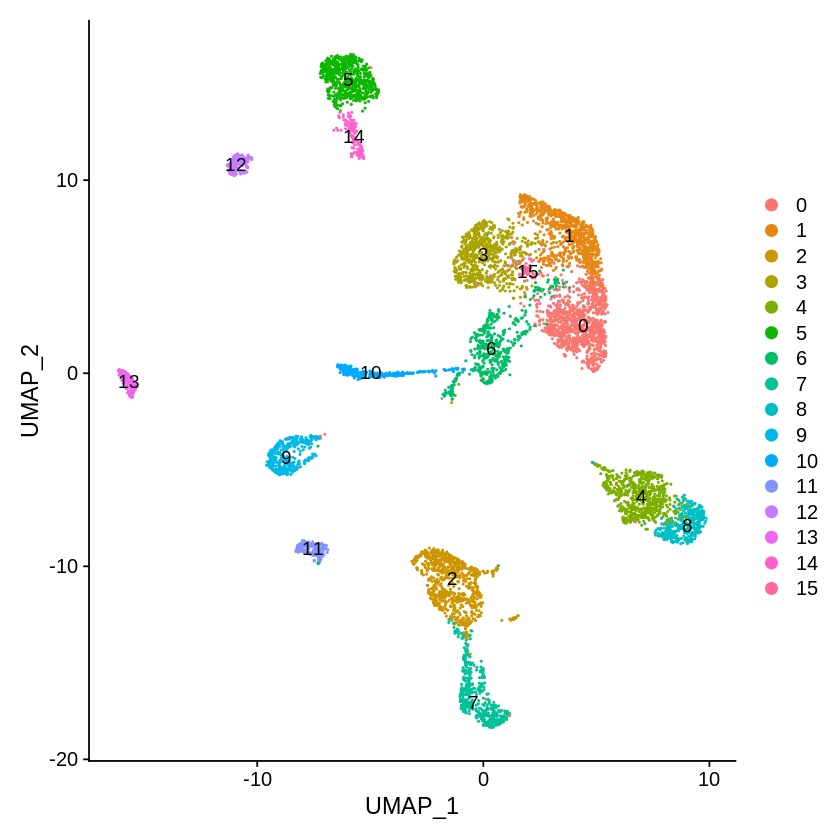

In [13]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [25]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

In [20]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



In [14]:
hcad.label <- c('Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Nerve tissue-Excitatory neuron-CAMK2A', 'Brain-Nerve tissue-VIP Inhibitory neuron-VIP',
                    'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-PV Inhibitory neuron-PVALB',
                    'Brain-Nerve tissue-Astrocyte-AQP4', 'Brain-Nerve tissue-Oligodendrocyte-MBP and OLIG1', 'Brain-Nerve tissue-Microglia-CX3CR1',
                    'Brain-Nerve tissue-Granule cell-GRM4', 'Brain-Nerve tissue-Oligodendrocyte precursor cell-OLIG2', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Excitatory neuron-PTK2B')
names(hcad.label) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, hcad.label)

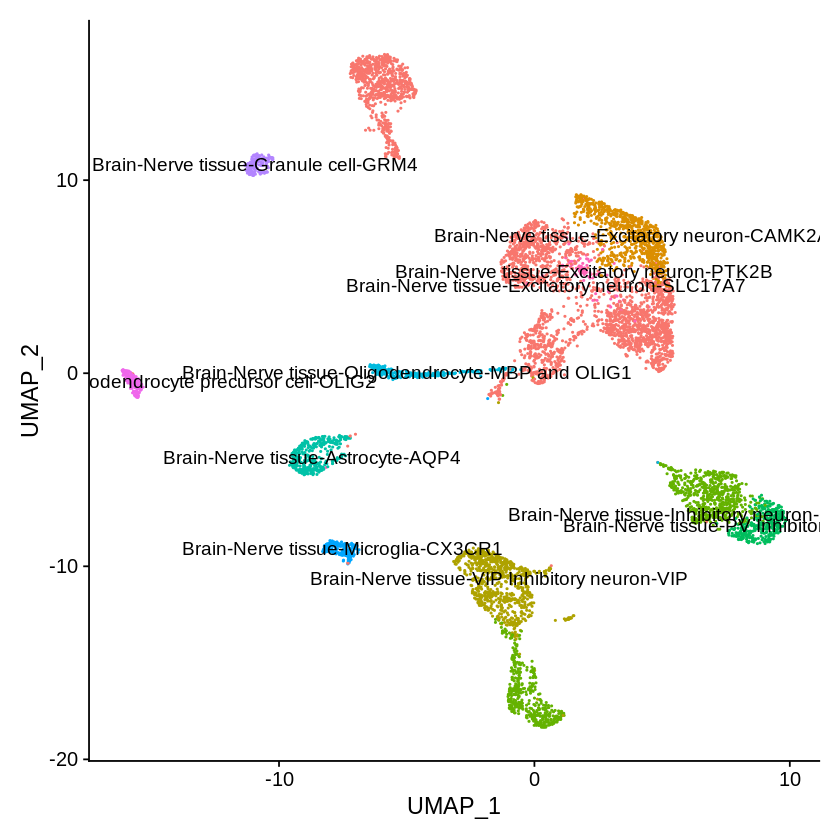

In [15]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [31]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [16]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))